In [1]:
import numpy as np

from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from numpy.linalg import norm
from numpy.random import normal
from copy import copy

In [2]:
def generate_halfmoons(n_samples,noise,verbose=True):
    X , y = make_moons(n_samples,noise=noise)

    if verbose  : plt.scatter(X[:,0],X[:,1],c=y)
    
    return X , y

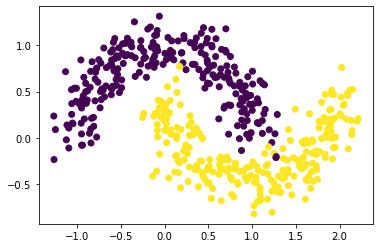

In [3]:
n_samples = 500
noise = 0.15
X , y = generate_halfmoons(n_samples,noise,verbose=True)

In [4]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7)

In [5]:
rd_model = RandomForestClassifier(max_depth=5)
rd_model.fit(X_train,y_train)
rd_model.predict(X_train[0].reshape(1,2))

array([0])

In [13]:
def uniform_in_sphere(x,n_samples,a_0,a_1):
    d = x.shape[0]
    
    # sample from gaussian distribution 
    samples = normal(0,1,(n_samples,d))
    
    # normalization
    samples_norm = samples / norm(samples,axis=1).reshape(-1,1)
    
    # sample from uniform distribution 
    u = np.random.uniform(a_0**d,a_1**d,1) ** (1/d)
    
    return x + samples_norm * u
    

def algorithme_gs_generation(model,sample,eta,n_samples):
    
    generated_samples_sph = uniform_in_sphere(sample,n_samples,0,eta)
    
    prediction_samples_sph = model.predict(generated_samples_sph)

    while np.where(prediction_samples_sph != model.predict(sample.reshape(1,2)),1,0).sum() != 0:
        
        eta = eta / 2
        
        generated_samples_sph = uniform_in_sphere(sample,n_samples,0,eta)
        
        prediction_samples_sph = model.predict(generated_samples_sph)
        
    a_0 = eta
    a_1 = 2*eta
    
    while np.where(prediction_samples_sph != model.predict(sample.reshape(1,2)),1,0).sum() == 0:
        
        generated_samples_sph = uniform_in_sphere(sample,n_samples,a_0,a_1)
        
        prediction_samples_sph = model.predict(generated_samples_sph)
        
        a_0 = a_1
        a_1 = a_1 + eta
        
    prediction_samples_sph = model.predict(generated_samples_sph)
    samples_diff_class = generated_samples_sph[np.where(prediction_samples_sph != model.predict(sample.reshape(1,2)))]
    
    enemy_ind = np.argmin(norm(np.array(samples_diff_class) - np.array(sample),axis=1))

    return samples_diff_class[enemy_ind]


def algorithme_gs_feature_selection(model,sample,enemy):
    
    enemy_prime = copy(enemy)

    while model.predict(sample.reshape(1,2)) != model.predict(enemy_prime.reshape(1,2)):

        enemy_star = copy(enemy_prime)
        
        # extraire uniquement les dimensions differentes
        indices_diffe_dim = np.where(enemy_prime != sample)[0]
        
        indi = indices_diffe_dim[np.argmin(enemy_prime[indices_diffe_dim] - sample[indices_diffe_dim])]

        enemy_prime[indi] = sample[indi]

    return enemy_star


def plot_decision_boundary(X, y, model,sample,contrf,title="Counterfactual"):
    # Crée une grille de points pour le tracé
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    # Prédire la classe pour chaque point de la grille
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Trace la frontière de décision et les points de données
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    
    if sample is not None:
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
        plt.scatter(sample[0], sample[1], c='red', marker='o', s=50, label='Sample')
        plt.scatter(contrf[0], contrf[1], c='yellow', marker='X', s=50, label=title)
    else:
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.title("Grawing Sphere "+title)
    plt.xlabel("dim 1")
    plt.ylabel("dim 2")
    plt.legend()
    plt.show()

Sample  : 
[-0.80888704  0.12501527]


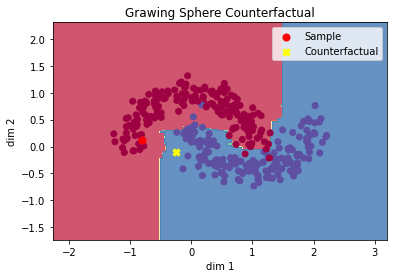

Counterfactual : 
[-0.25743552 -0.0950117 ]


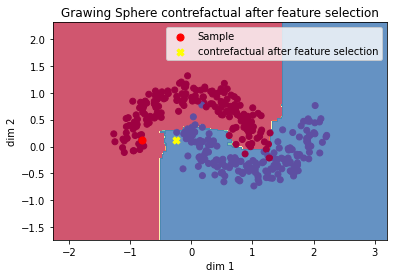

Counterfactual after feature selection
[-0.25743552  0.12501527]


In [14]:
sample = X_train[0]
print("Sample  : ")
print(sample)

enemy = algorithme_gs_generation(rd_model,sample,eta=6,n_samples=10)
plot_decision_boundary(X_train, y_train, rd_model,sample,enemy)
print("Counterfactual : ")
print(enemy)

enemy_star = algorithme_gs_feature_selection(rd_model,sample,enemy)
plot_decision_boundary(X_train, y_train, rd_model,sample,enemy_star,"contrefactual after feature selection")
print("Counterfactual after feature selection")
print(enemy_star)